# Onset date analysis in Angola
### JLD, 07/11/2020

In [100]:
## Import packages ##

import sys
import os
import os.path as pa
import glob

from osgeo import gdal
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import scipy.io
import scipy.stats as stats
from sklearn.decomposition import PCA

from rasterstats import zonal_stats, point_query
import datetime as dt
from datetime import timedelta
from netCDF4 import Dataset,num2date
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import seaborn as sns
%matplotlib inline

import cdsapi
    
    

# Parameters

In [2]:
# Path
path='./'
# Period
period=pd.period_range(start='1/01/1981', end='12/31/2010') 
years=pd.period_range(start='1/01/1981', end='12/31/2011',freq='Y') 
mm=1
dd=1
# Domain
lonmin=15
lonmax=17
latmin=-13
latmax=-9


# ERA5-Land data download

In [ ]:
c = cdsapi.Client()

#loops over years
for current_year in tqdm(years): 
    year=current_year.year
    
    c.retrieve(
    'reanalysis-era5-land',
    {
        'variable': 'total_precipitation',
        'year': year,
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',      
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [latmax, lonmin, latmin,lonmax], # North, West, South, East   
        'format': 'netcdf',
    },
     pa.join(path,'era5land_rr_hourly_'+str(abs(latmax))+'S'+str(lonmin)+'E'+
                                        str(abs(latmin))+'S'+str(lonmax)+'E_'+ 
                                        str(year) +'.nc'))  

## ERA5 preprocessing

In [40]:
###############################################################
# Daily agregation with cdo

#loops over years
for current_year in tqdm(years): 
    year=current_year.year
    
    inputfile='era5land_rr_hourly_'+str(abs(latmax))+'S'+str(lonmin)+'E'+ \
                                    str(abs(latmin))+'S'+str(lonmax)+'E_'+  \
                                    str(year) +'.nc'
    outputfile='era5land_rr_daily_'+str(abs(latmax))+'S'+str(lonmin)+'E'+ \
                                    str(abs(latmin))+'S'+str(lonmax)+'E_'+  \
                                    str(year) +'.nc'

    !cdo -b F64 daysum $path/$inputfile $path/$outputfile


  0%|          | 0/30 [00:00<?, ?it/s]

cdo    daysum: Processed 1 variable over 9123 timesteps [27.00s 158MB].


  3%|▎         | 1/30 [00:27<13:08, 27.18s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [24.90s 158MB].


  7%|▋         | 2/30 [00:52<12:23, 26.54s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [25.53s 158MB].


 10%|█         | 3/30 [01:17<11:49, 26.29s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [25.36s 158MB].


 13%|█▎        | 4/30 [01:43<11:17, 26.06s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [25.03s 158MB].


 17%|█▋        | 5/30 [02:08<10:44, 25.80s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.44s 158MB].


 20%|██        | 6/30 [02:36<10:32, 26.34s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.28s 158MB].


 23%|██▎       | 7/30 [03:03<10:13, 26.68s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [26.66s 158MB].


 27%|██▋       | 8/30 [03:30<09:48, 26.73s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [26.65s 158MB].


 30%|███       | 9/30 [03:57<09:21, 26.75s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.41s 158MB].


 33%|███▎      | 10/30 [04:24<08:59, 26.99s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [26.19s 158MB].


 37%|███▋      | 11/30 [04:51<08:29, 26.80s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [26.16s 158MB].


 40%|████      | 12/30 [05:17<07:59, 26.66s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.51s 158MB].


 43%|████▎     | 13/30 [05:45<07:38, 26.97s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.21s 158MB].


 47%|████▋     | 14/30 [06:12<07:13, 27.09s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [25.65s 158MB].


 50%|█████     | 15/30 [06:38<06:40, 26.71s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [26.29s 158MB].


 53%|█████▎    | 16/30 [07:04<06:12, 26.63s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [26.57s 158MB].


 57%|█████▋    | 17/30 [07:31<05:46, 26.66s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [25.54s 158MB].


 60%|██████    | 18/30 [07:57<05:16, 26.38s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [26.59s 158MB].


 63%|██████▎   | 19/30 [08:24<04:51, 26.49s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [27.72s 158MB].


 67%|██████▋   | 20/30 [08:52<04:29, 26.90s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.30s 158MB].


 70%|███████   | 21/30 [09:19<04:03, 27.07s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.29s 158MB].


 73%|███████▎  | 22/30 [09:46<03:37, 27.18s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.57s 158MB].


 77%|███████▋  | 23/30 [10:14<03:11, 27.35s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [28.69s 158MB].


 80%|████████  | 24/30 [10:43<02:46, 27.80s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.39s 158MB].


 83%|████████▎ | 25/30 [11:11<02:18, 27.73s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [27.69s 158MB].


 87%|████████▋ | 26/30 [11:38<01:51, 27.77s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [28.84s 158MB].


 90%|█████████ | 27/30 [12:07<01:24, 28.14s/it]

cdo    daysum: Processed 1 variable over 9149 timesteps [27.71s 158MB].


 93%|█████████▎| 28/30 [12:35<00:56, 28.06s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [25.27s 158MB].


 97%|█████████▋| 29/30 [13:01<00:27, 27.27s/it]

cdo    daysum: Processed 1 variable over 9124 timesteps [25.20s 158MB].


100%|██████████| 30/30 [13:26<00:00, 26.89s/it]


In [3]:
## Concatenation of daily files
#!cdo -b F64 merge era5land_rr_daily_9S15E13S17E_*.nc era5land_rr_daily_9S15E13S17E_1981_2010.nc
!cdo -b F64 mergetime era5land_rr_daily_9S15E13S17E_1981.nc \
                      era5land_rr_daily_9S15E13S17E_1982.nc \
                      era5land_rr_daily_9S15E13S17E_1983.nc \
                      era5land_rr_daily_9S15E13S17E_1984.nc \
                      era5land_rr_daily_9S15E13S17E_1985.nc  \
                      era5land_rr_daily_9S15E13S17E_1986.nc  \
                      era5land_rr_daily_9S15E13S17E_1987.nc  \
                      era5land_rr_daily_9S15E13S17E_1988.nc  \
                      era5land_rr_daily_9S15E13S17E_1989.nc  \
                      era5land_rr_daily_9S15E13S17E_1990.nc  \
                      era5land_rr_daily_9S15E13S17E_1991.nc  \
                      era5land_rr_daily_9S15E13S17E_1992.nc  \
                      era5land_rr_daily_9S15E13S17E_1993.nc  \
                      era5land_rr_daily_9S15E13S17E_1994.nc  \
                      era5land_rr_daily_9S15E13S17E_1995.nc  \
                      era5land_rr_daily_9S15E13S17E_1996.nc  \
                      era5land_rr_daily_9S15E13S17E_1997.nc  \
                      era5land_rr_daily_9S15E13S17E_1998.nc  \
                      era5land_rr_daily_9S15E13S17E_1999.nc  \
                      era5land_rr_daily_9S15E13S17E_2000.nc  \
                      era5land_rr_daily_9S15E13S17E_2001.nc  \
                      era5land_rr_daily_9S15E13S17E_2002.nc  \
                      era5land_rr_daily_9S15E13S17E_2003.nc  \
                      era5land_rr_daily_9S15E13S17E_2004.nc  \
                      era5land_rr_daily_9S15E13S17E_2005.nc  \
                      era5land_rr_daily_9S15E13S17E_2006.nc  \
                      era5land_rr_daily_9S15E13S17E_2007.nc  \
                      era5land_rr_daily_9S15E13S17E_2008.nc  \
                      era5land_rr_daily_9S15E13S17E_2009.nc  \
                      era5land_rr_daily_9S15E13S17E_2010.nc  \
                      era5land_rr_daily_9S15E13S17E_2011.nc  \
                      era5land_rr_daily_9S15E13S17E_1981_2011.nc

cdo    mergetime: Processed 31 variables over 11322 timesteps [1.70s 133MB].


In [4]:
## Monitoring daily agregation with cdo
yyyy=1990
!cdo sinfo era5land_rr_daily_9S15E13S17E_"$yyyy".nc

!cdo sinfo era5land_rr_daily_9S15E13S17E_1981_2011.nc

   File format : NetCDF2
    -1 : Institut Source   T Steptype Levels Num    Points Num Dtype : Parameter ID
     1 : unknown  unknown  v instant       1   1       861   1  F64  : -1            
   Grid coordinates :
     1 : lonlat                   : points=861 (21x41)
                        longitude : 15 to 17 by 0.1 degrees_east
                         latitude : -9 to -13 by -0.1 degrees_north
   Vertical coordinates :
     1 : surface                  : levels=1
   Time coordinate :  365 steps
     RefTime =  1900-01-01 00:00:00  Units = hours  Calendar = gregorian  Bounds = true
  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss  YYYY-MM-DD hh:mm:ss
  1990-01-01 11:00:00  1990-01-02 11:00:00  1990-01-03 11:00:00  1990-01-04 11:00:00
  1990-01-05 11:00:00  1990-01-06 11:00:00  1990-01-07 11:00:00  1990-01-08 11:00:00
  1990-01-09 11:00:00  1990-01-10 11:00:00  1990-01-11 11:00:00  1990-01-12 11:00:00
  1990-01-13 11:00:00  1990-01-14 11:00:00  1990-01-15 11:00:00 

# Onset date computation

In [3]:
def datestdtojd (stddate):
    '''From standard Date to Julian date'''
    fmt='%Y-%m-%d'
    sdtdate = dt.datetime.strptime(stddate, fmt)
    sdtdate = sdtdate.timetuple()
    jdate = sdtdate.tm_yday
    return(jdate)

In [4]:
def anomalous_accumulation(yyyy,mm,dd,input_file):
    '''
    Function to compute the Anomalous Accumulation (AA) Indice
    anf get the onset date which is the date of AA minimum
    inputs: 
    year, month,day : integer between 1981 and 2010
    input_file : netcdf file of annual daily precipitation     
    '''
    
    if yyyy>=1981 and yyyy <= 2010:
        
        try:
             
            deb=dt.datetime(1981,1,1)
            fin=dt.datetime(2011,12,31)
            period=pd.period_range(start=deb, end=fin) 
            debsub=dt.datetime(yyyy,mm,dd)
            finsub=debsub+timedelta(days=364)
            subperiod=pd.period_range(start=debsub, end=finsub) 
            
            data = Dataset(input_file,mode='r')
            rr=data['tp'][:]
            lon=data['longitude'][:]
            lat=data['latitude'][:]
            time=data.variables['time']
            dates=num2date(time[:],time.units,time.calendar)
            
            ## Subperiod extract
            idx_start=np.where(period==subperiod[0])
            idx_end=np.where(period==subperiod[-1])
            rr=rr[idx_start[0][0]:idx_end[0][0],:,:]
            time=time[idx_start[0][0]:idx_end[0][0]]
            
            ## Reshape rr to a 2D array
            rr=np.reshape(rr,[len(time),len(lat)*len(lon)])

            # RRcum. avg computation
            rr_cum=np.sum(rr,axis=0)
            rr_cumavg= rr_cum / len(time)

            ## Anomalous Accumulation
            AA = np.cumsum(rr - rr_cumavg,axis=0)

            ## Onset date : minimum of AA time serie
            onset_date=[subperiod[np.where(AA[:,idx]==np.min(AA[:,idx]))] 
                        for idx in range(len(lat)*len(lon))]

            onset_julian=[datestdtojd(str(onset_date[idx][0]))
                          for idx in range(len(lat)*len(lon))]
            
            return(AA,onset_date,onset_julian,lon,lat)

        except:
            print('Unexpected error:',sys.exc_info()[0])
            pass

    else:
        print('year must be between 1981 and 2010')


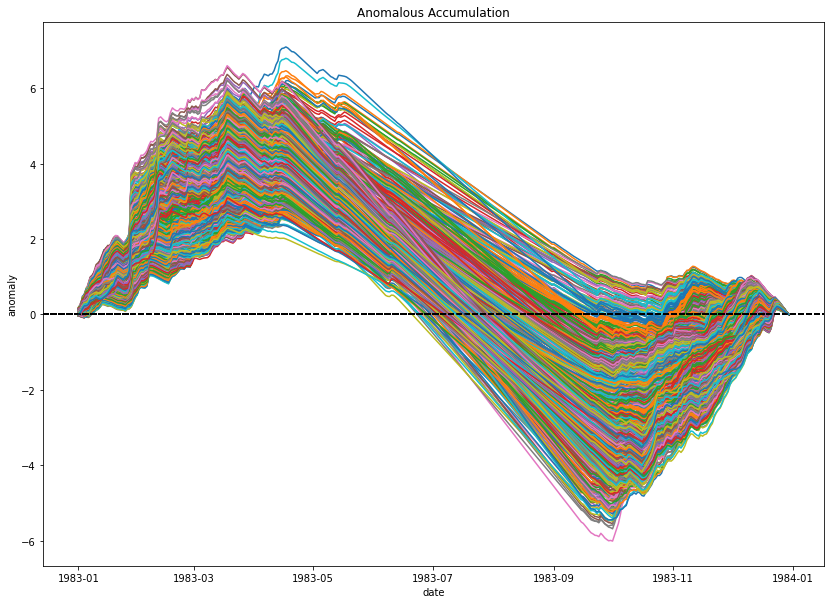

In [72]:
# Test AA function for the whole grid-points, for a 1 year period
yyyy=1983
result=anomalous_accumulation(yyyy,mm,dd,'era5land_rr_daily_9S15E13S17E_1981_2011.nc')

fig, ax = plt.subplots(figsize=(14,10))
AA=result[0]
start=dt.date(yyyy,mm,dd)
xaxis=[start + dt.timedelta(days=i) for i in range(364)]

for i in range(0,861):
    plt.plot(xaxis,AA[:,i])
    plt.axhline(y=0.0, color='black', linestyle='--')
    plt.xlabel('date')
    plt.ylabel('anomaly')
    plt.title('Anomalous Accumulation')

fig.savefig(pa.join(path,'AA_'+str(yyyy)+'.png'))

#### Onset date computation for the period 1981-2010

In [6]:
onset_period=[]

for year in years:
    if year.year == 2011:
        break
    else:
        print(year)
        year=year.year
        result=anomalous_accumulation(year,mm,dd,'era5land_rr_daily_9S15E13S17E_1981_2011.nc')
        onset_julian=result[2]
        onset_period.append(onset_julian)
    
### Onset result recording with pickel
with open(pa.join(path,'output_onset_date_1981-2010_start1-jan.pkl'), 'wb') as fh:
    pickle.dump(onset_period, fh)

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


#### Onset date temporal evolution over the period 1981-2010
#### for each grid point of the domain

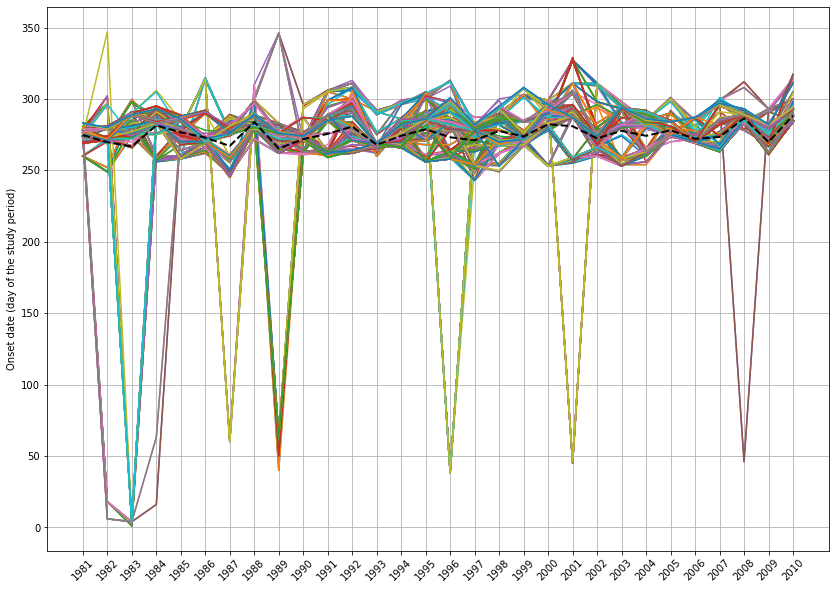

In [9]:
lon=result[3]
lat=result[4]
onset_period=np.reshape(onset_period,[len(years)-1,len(lon)*len(lat)])
yyyy_idx=list(range(1981,2010+1))
avg_onset=np.mean(onset_period,1)

fig, ax = plt.subplots(figsize=(14, 10))
plt.plot(yyyy_idx,onset_period)
plt.plot(yyyy_idx,avg_onset, color = 'black', linestyle = 'dashed', linewidth = 2)
plt.ylabel('Onset date (day of the study period)')

plt.xticks(np.arange(min(yyyy_idx),max(yyyy_idx)+1,1),rotation=45)

plt.grid()
plt.show()

### Spatial representation of the Onset date


##### Spatial distribution of Onset date year by year

/home/julien/anaconda3/envs/radar/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


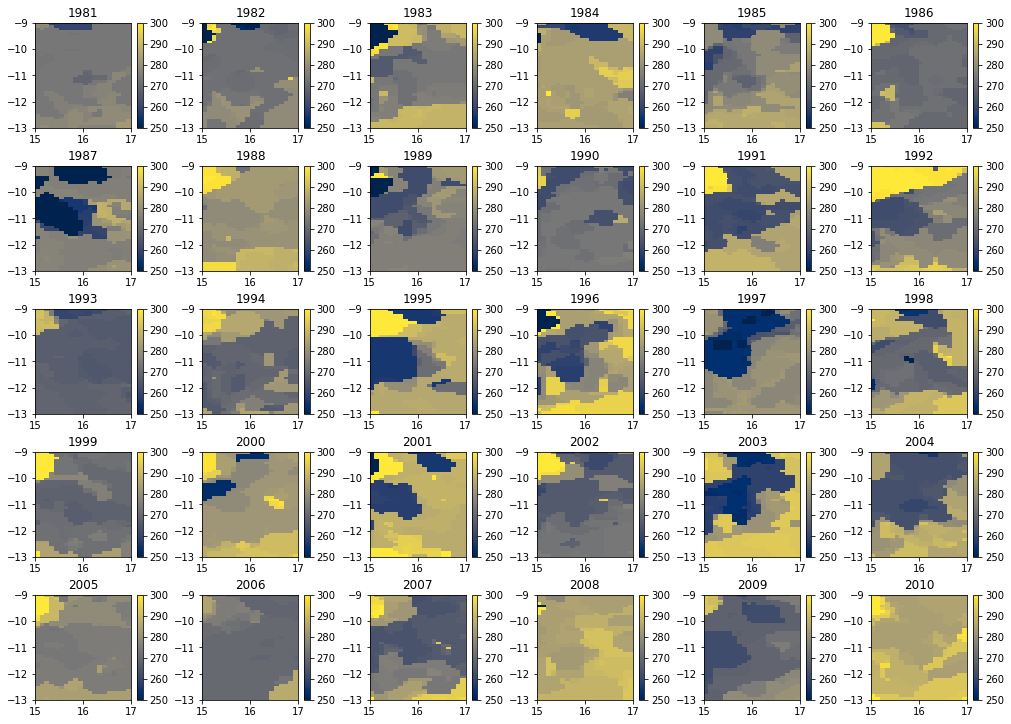

In [11]:
savefig=0

onset_period=np.reshape(onset_period,[len(years)-1,len(lat),len(lon)])

fig, ax = plt.subplots(figsize=(14, 10))
ax=plt.axes(projection=ccrs.PlateCarree())

for idx in range(0,len(years)-1):
    nrows=len(years)//6
    ncols=len(years)//nrows
    plt.subplot(nrows,ncols,idx+1)
    #COLORMESH
    plt.pcolormesh(lon,lat,onset_period[idx,:,:],
               vmin=250,vmax=300,cmap='cividis')
    plt.colorbar()
    plt.title(str(years[idx].year))
    
fig.tight_layout(pad=0.5)
plt.show()

if savefig ==1:
    fig.savefig(pa.join(path,'onset_date_1981_2010.png'))


##### Averaged map over 1981-2010 period

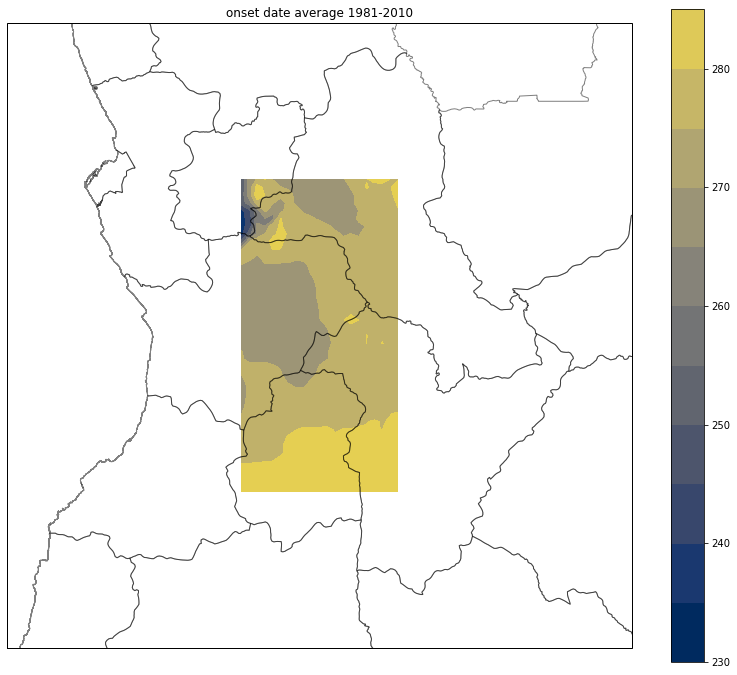

In [18]:
savefig=1
angola_shp =  list(shpreader.Reader((pa.join(path,'gadm36_AGO_shp','gadm36_AGO_1.shp'))).geometries())
vmin=230;vmax=290

fig, ax = plt.subplots(figsize=(14, 12))
ax=plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon,lat,np.mean(onset_period,axis=0),
             vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),
             cmap='cividis')
m = plt.cm.ScalarMappable(cmap='cividis')
m.set_array(np.mean(onset_period,axis=0))
m.set_clim(vmin,vmax)
plt.colorbar(m,boundaries=np.arange(vmin,vmax,5))

plt.title('onset date average 1981-2010')
ax.add_geometries(angola_shp,ccrs.PlateCarree(),
                  edgecolor='black',facecolor='none',alpha=0.5)
ax.set_extent([lonmin-3, lonmax+3, latmin-2, latmax+2], ccrs.PlateCarree())
plt.show()

if savefig==1:
    fig.savefig(pa.join(path,'onset_date_average_1981_2010_v3.png'))

# Spatio-temporal analysis by EOF/PCA

In [19]:
onset_period=np.reshape(onset_period,[len(years)-1,len(lat)*len(lon)])
np.shape(onset_period)

X=np.transpose(onset_period)
pc_numbers=10
model=PCA(n_components=pc_numbers)
X_reduced=model.fit_transform(X)

In [20]:
print(np.shape(X_reduced))
print(np.shape(model.components_))

(861, 10)
(10, 30)


Text(0, 0.5, 'variance')

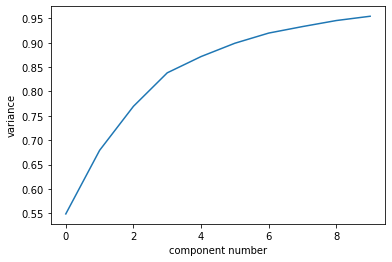

In [21]:
# Cumulative variance 
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('component number')
plt.ylabel(('variance'))

In [95]:
# Graphical representation

In [50]:
print(np.max(pca_result[:,:,1]))
print(np.min(pca_result[:,:,1]))


279.5422829278387
-210.67329353229312


In [22]:
pca_result=np.reshape(X_reduced,[len(lat),len(lon),pc_numbers])

In [68]:
def pca_plot(mode):

    fig, ax = plt.subplots(figsize=(14, 14))

    ax=plt.axes(projection=ccrs.PlateCarree())
    #divnorm = mcolors.TwoSlopeNorm(vmin=-100., vcenter=0, vmax=650)
    divnorm = mcolors.TwoSlopeNorm(vmin=np.min(pca_result[:,:,mode-1]),
                                   vcenter=0,
                                   vmax=np.max(pca_result[:,:,mode-1]))
    
    plt.contourf(lon,lat,pca_result[:,:,mode-1],
                 transform=ccrs.PlateCarree(),
                 norm=divnorm,
                 cmap='RdBu_r')
    plt.colorbar()

    plt.title('eigenvector '+str(mode))
    ax.add_geometries(angola_shp,ccrs.PlateCarree(),
                      edgecolor='black',facecolor='none',alpha=0.5)
    ax.set_extent([lonmin-3, lonmax+3, latmin-2, latmax+2], ccrs.PlateCarree())

    fig.savefig(pa.join(path,'onset_date_mode'+str(mode)+'.png'))
    ########################################################################
    fig, ax = plt.subplots(figsize=(14, 8))
    plt.plot(yyyy_idx,model.components_[mode-1,:],marker='o')
    plt.axhline(y=0.0, color='black', linestyle='--')
    plt.xticks(np.arange(min(yyyy_idx),max(yyyy_idx)+1,1),rotation=45)
    plt.grid()
    plt.title('PC '+str(mode)+' / '+str(round(model.explained_variance_ratio_[mode-1]*100,2))+'%')
    plt.show()
    fig.savefig(pa.join(path,'onset_date_pc'+str(mode)+'.png'))


/home/julien/anaconda3/envs/radar/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


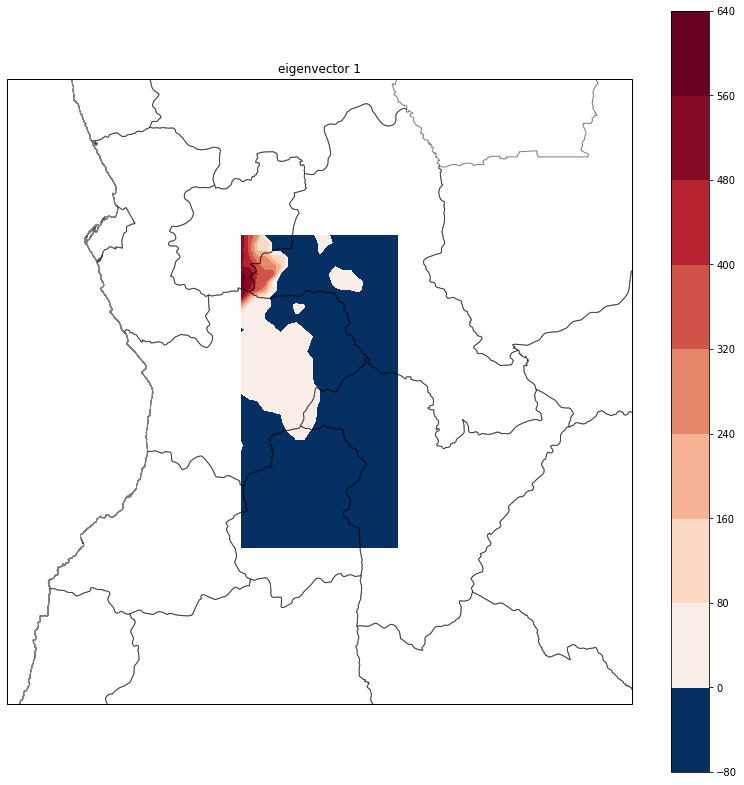

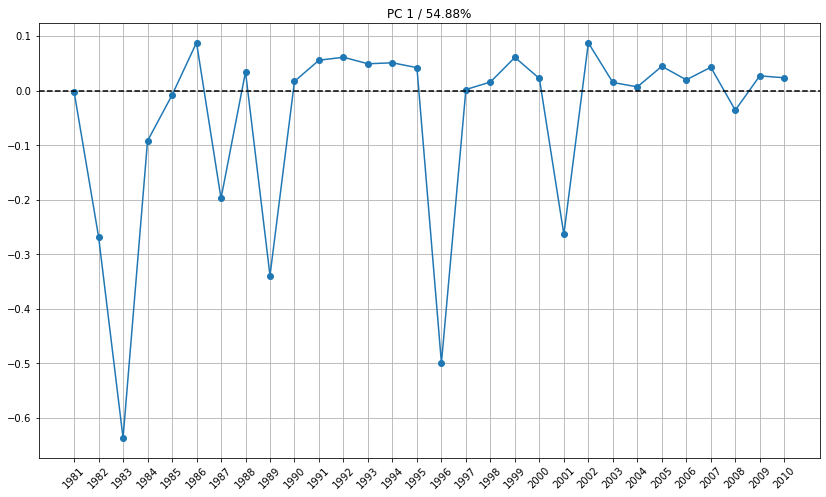

In [69]:
pca_plot(1)

/home/julien/anaconda3/envs/radar/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


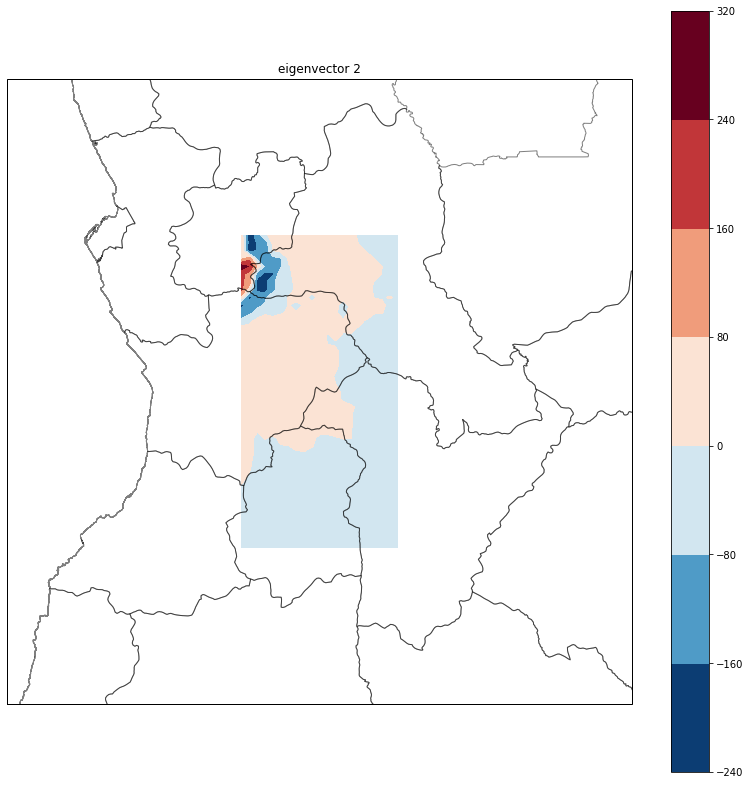

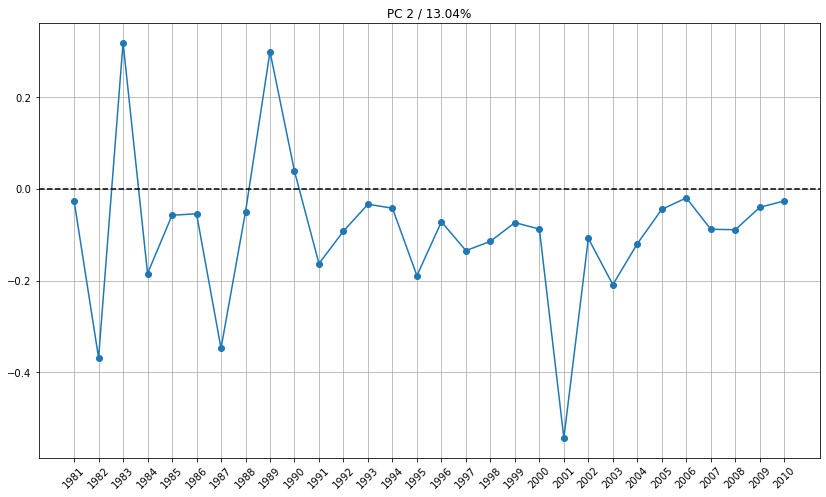

In [70]:
pca_plot(2)

/home/julien/anaconda3/envs/radar/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


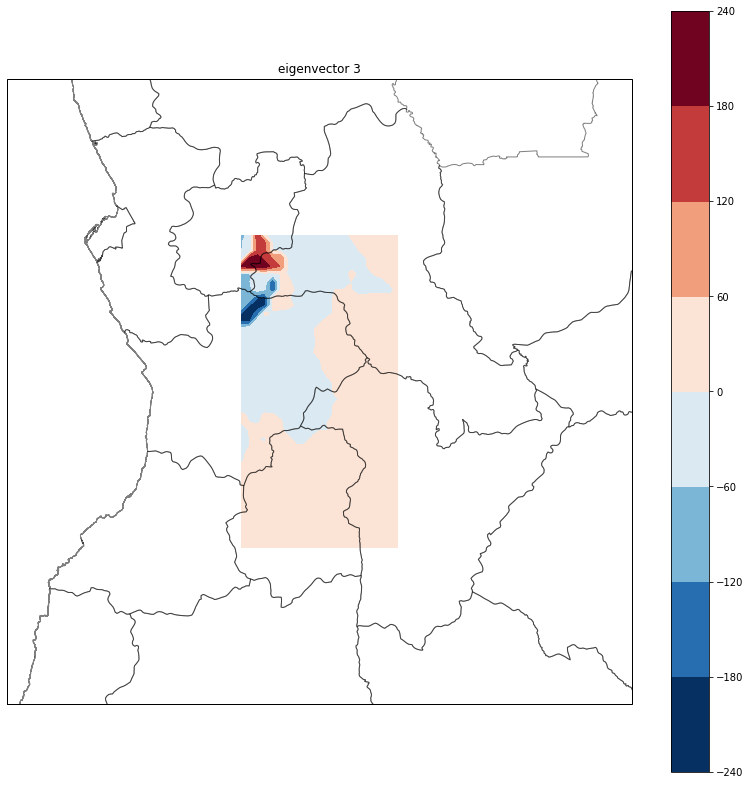

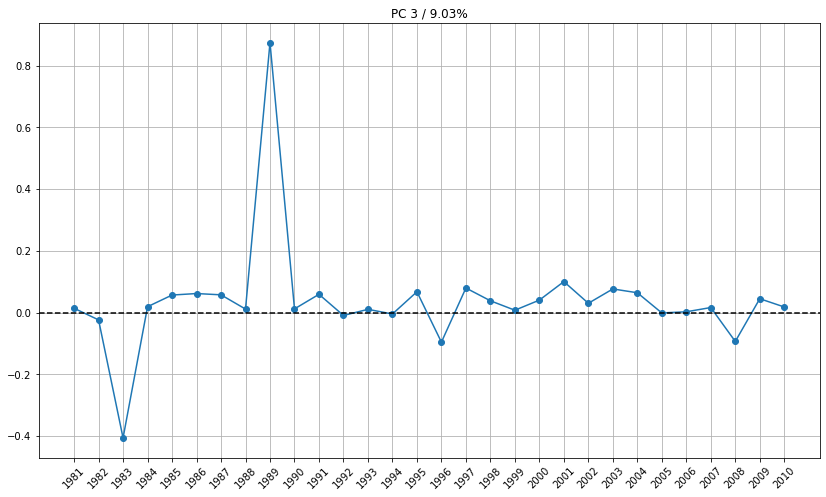

In [71]:
pca_plot(3)

# Temporal Variability study
## Huambo: [9.55S; 16.34E]
## Malange: [12.77S; 15.73E]


## Extraction of Time-series for both stations
### closer ERA5 grid-point 

In [75]:
### opening of onset date computation
with open(pa.join(path,'output_onset_date_1981-2010_start1-jan.pkl'), 'rb') as fh:
    onset_date = pickle.load(fh)

In [77]:
onset_date=np.reshape(onset_date,[len(years)-1,len(lat),len(lon)])
np.shape(onset_date)

(30, 41, 21)

In [78]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [79]:
# Extraction of the nearest grid-point for each City
lat_malanje= np.where(lat == find_nearest(lat,-9.55))
lon_malanje= np.where(lon == find_nearest(lon,16.34))
lat_huambo= np.where(lat == find_nearest(lat,-12.77))
lon_huambo= np.where(lon == find_nearest(lon,15.73))

In [80]:
onset_huambo=onset_date[:,lat_huambo,lon_huambo]
onset_malanje=onset_date[:,lat_malanje,lon_malanje]

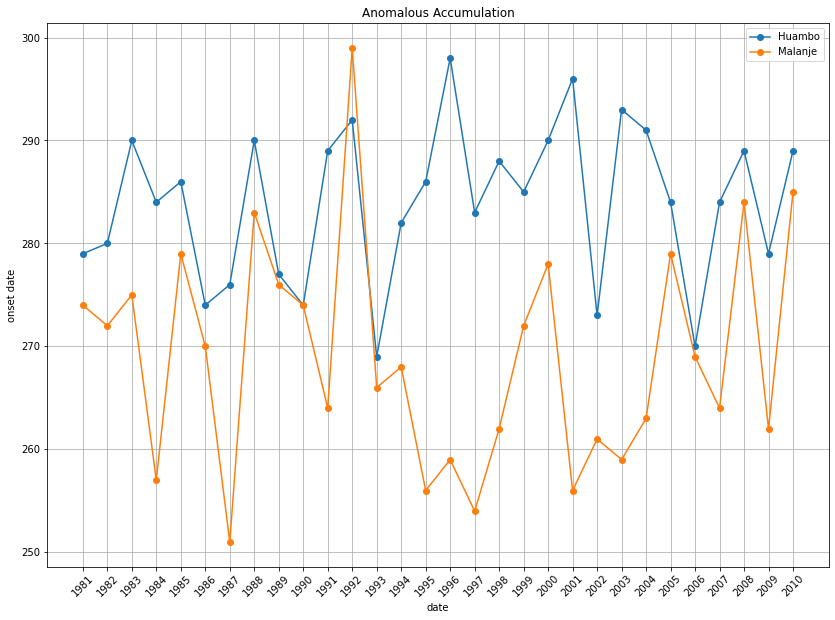

In [217]:
fig, ax = plt.subplots(figsize=(14,10))
b1,=plt.plot(yyyy_idx,onset_huambo[:,0,0],marker='o',label='Huambo')
b2,=plt.plot(yyyy_idx,onset_malanje[:,0,0],marker='o',label='Malanje')
plt.xticks(np.arange(min(yyyy_idx),max(yyyy_idx)+1,1),rotation=45)
plt.grid()
plt.xlabel('date')
plt.ylabel('onset date')
plt.legend(handles=[b1,b2])
plt.title('Anomalous Accumulation')
fig.savefig(pa.join(path,'onset_ts_cities_1981_2010.png'))

In [87]:
#### Avg. and std computation for each TS
print('Huambo avg: ', np.mean(onset_huambo))
print('Huambo std: ', np.std(onset_huambo))
print('Malanje avg: ', np.mean(onset_malanje))
print('Malanje std: ', np.std(onset_malanje))

Huambo avg:  284.0
Huambo std:  7.4565407529228995
Malanje avg:  269.03333333333336
Malanje std:  10.802725993418925


/home/julien/anaconda3/envs/radar/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/julien/anaconda3/envs/radar/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


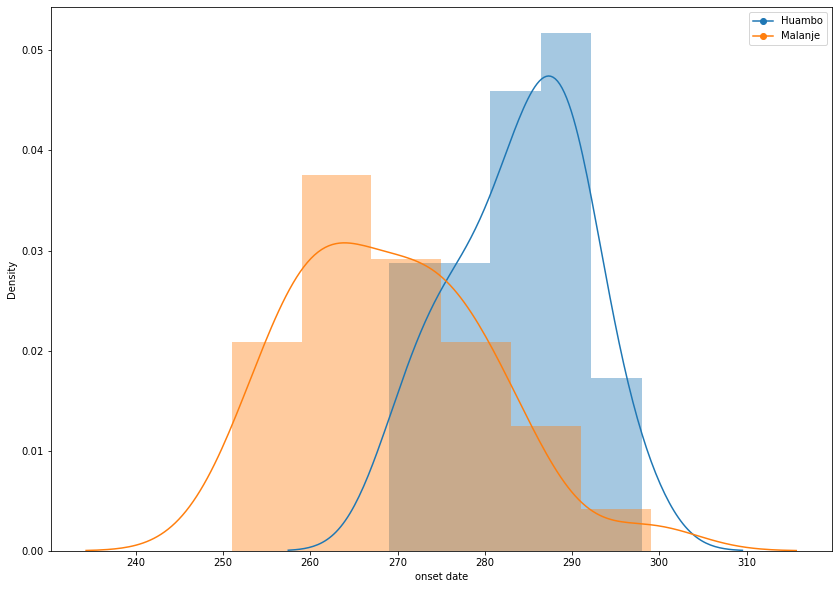

In [218]:
fig, ax = plt.subplots(figsize=(14,10))

sns.distplot(onset_huambo[:,0,0])
sns.distplot(onset_malanje[:,0,0])
plt.xlabel('onset date')
plt.legend(handles=[b1,b2])
fig.savefig(pa.join(path,'onset_ts_distribution_cities_1981_2010.png'))

#### Test of Kolmogorov-Smirnov (KS test) to evaluate the normality of the distributions

In [97]:
onset_huambo_cr=(onset_huambo[:,0,0] - np.mean(onset_huambo[:,0,0])) / np.std(onset_huambo[:,0,0])
onset_malanje_cr=(onset_malanje[:,0,0] - np.mean(onset_malanje[:,0,0])) / np.std(onset_malanje[:,0,0])

In [98]:
stats.kstest(onset_huambo_cr,'norm')

KstestResult(statistic=0.11541375393380493, pvalue=0.777000837370371)

In [99]:
stats.kstest(onset_malanje_cr,'norm')

KstestResult(statistic=0.11270116650915574, pvalue=0.8002790599413443)